# Front Matter: CASA0013: Foundations of Spatial Data Science

## Title of Briefing <font color='red'>edit</font> 

### Student ID: 21203086 

### Word Count: <font color='red'>edit</font> 

# Reproducible Analysis

## Inroduction-overview

This notebook holds the analysis for the classification of Airbnb penetration in London. 
After a first exploration of the datasets with visualisations that seek to quantify the current picture of Airbnb listings in London, the London wards are classified by their amaount of listings (low, medium, large), followed by a geodemographic classification of the neighboorhods that attempts to identify patterns expaining and perhaps predicting the presence or absense of listings. 

<font color='red'>edit</font> 

Data used for this analysis were obtained from the following sources:
* Airbnb listings, compiled 10 October 2021: <http://insideairbnb.com/get-the-data.html>
* London Wards data: <https://data.london.gov.uk/dataset/ward-profiles-and-atlas>
* London Wards geography: <https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london>


For ease of access the data has been saved in the following github repository: <https://github.com/DaphneBdn/fsds_cw3> 

This analysis also uses data provided by the course material: <font color='red'>ADD HERE</font> 




## Libraries

<font color='red'>edit:add all</font> 

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns

## Data import

### London Boundary 

First create a background map of London that can be used for visualisations.

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


<AxesSubplot:>

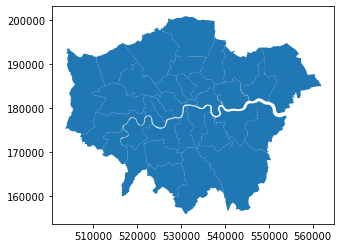

In [3]:
# Load the London Boroughs geopackage 

boros = gpd.read_file('https://github.com/DaphneBdn/fsds_assessment3/blob/main/Data/geo/Boroughs.gpkg?raw=true')
boros.plot()

In [4]:
# Convert to a geodataframe by setting the CRS to the British National grid with EPSG 27700
ldn = gpd.GeoDataFrame(gpd.GeoSeries(data=boros.unary_union, crs='epsg:27700')).rename(columns={0:'original'})

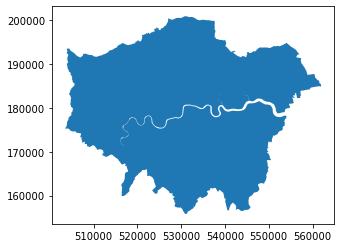

In [5]:
# Create the London shape (for later use)
ldn['geometry'] = ldn.original.buffer(20)
ldn_shape = ldn.set_geometry('geometry')
ldn_shape.plot();

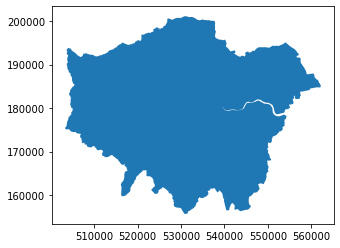

In [6]:
# Create the London boundary (for later use)
ldn['geometry'] = ldn.original.buffer(200)
ldn = ldn.set_geometry('geometry')
ldn.plot();

### Airbnb Data

The London Airbnb listigns data set used here is the latest from [Inside Airbnb](http://insideairbnb.com/get-the-data.html), which according to the website was compiled on 10 October, 2021.

In [7]:
# Load in the Airbnb data 
df = pd.read_csv('https://github.com/DaphneBdn/fsds_assessment3/blob/main/Data/raw/listings.csv.gz?raw=true', compression='gzip')
df.head(3)

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,13913,https://www.airbnb.com/rooms/13913,20211010233627,2021-10-12,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,Finsbury Park is a friendly melting pot commun...,https://a0.muscache.com/pictures/miso/Hosting-...,54730,https://www.airbnb.com/users/show/54730,...,4.89,4.63,4.74,NaN,f,2,1,1,0,0.17
1,15400,https://www.airbnb.com/rooms/15400,20211010233627,2021-10-12,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,It is Chelsea.,https://a0.muscache.com/pictures/428392/462d26...,60302,https://www.airbnb.com/users/show/60302,...,4.82,4.93,4.73,NaN,f,1,1,0,0,0.79
2,17402,https://www.airbnb.com/rooms/17402,20211010233627,2021-10-12,Superb 3-Bed/2 Bath & Wifi: Trendy W1,You'll have a wonderful stay in this superb mo...,"Location, location, location! You won't find b...",https://a0.muscache.com/pictures/39d5309d-fba7...,67564,https://www.airbnb.com/users/show/67564,...,4.66,4.85,4.59,NaN,f,2,2,0,0,0.35


In [8]:
# extract the column names
cols=df.columns
print(cols)
print()
print(f"The Inside Airbnb dataset has {len(cols)} columns")

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

Reducing the number of columns to make the dataset more manageable and to get a better overview. Prepare for first exploration and summary statistics.

In [9]:
# store the columns of interest in a list
sub_cols=['id', 'name',
       'latitude','longitude', 'property_type', 'room_type', 'price',
       'availability_365', 'number_of_reviews_l30d', 'first_review',
       'last_review']
# create a subframe with the stored columns
df= df[sub_cols]
df.set_index('id', inplace=True)
df.head()


,name,latitude,longitude,property_type,room_type,price,availability_365,number_of_reviews_l30d,first_review,last_review
id,,,,,,,,,,
13913,Holiday London DB Room Let-on going,51.56861,-0.11270,Private room in rental unit,Private room,$65.00,339,0,2011-07-11,2011-09-13
15400,Bright Chelsea Apartment. Chelsea!,51.48780,-0.16813,Entire rental unit,Entire home/apt,$75.00,2,0,2012-07-16,2019-08-10
17402,Superb 3-Bed/2 Bath & Wifi: Trendy W1,51.52195,-0.14094,Entire rental unit,Entire home/apt,$307.00,320,0,2011-09-18,2019-11-02
17506,Boutique Chelsea/Fulham Double bed 5-star ensuite,51.47935,-0.19743,Private room in townhouse,Private room,$150.00,364,0,NaN,NaN
24328,"Battersea bedroom & studio, parking, shared ga...",51.47119,-0.16256,Entire townhouse,Entire home/apt,$200.00,273,0,2011-11-01,2015-10-24


### First dataset exploration

In [10]:
# change settings to display all rows
pd.set_option('display.max_rows', None)
# investigate NA values by printing out the count of NA values per column 
df.isna().sum().sort_values(ascending=False)

first_review              19028
last_review               19028
name                         24
latitude                      0
longitude                     0
property_type                 0
room_type                     0
price                         0
availability_365              0
number_of_reviews_l30d        0
dtype: int64

In [11]:
# change settings back 
pd.reset_option('all')

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/_config/config.py:630: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/_config/config.py:630: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


In [12]:
# check the datatype 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67903 entries, 13913 to 52717191
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    67879 non-null  object 
 1   latitude                67903 non-null  float64
 2   longitude               67903 non-null  float64
 3   property_type           67903 non-null  object 
 4   room_type               67903 non-null  object 
 5   price                   67903 non-null  object 
 6   availability_365        67903 non-null  int64  
 7   number_of_reviews_l30d  67903 non-null  int64  
 8   first_review            48875 non-null  object 
 9   last_review             48875 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 5.7+ MB


In [13]:
# size of dataframe
print(f"Data frame is {df.shape[0]:,} x {df.shape[1]}")

Data frame is 67,903 x 10


After inspecting the data the key things to note are: 
* There are 67903 listings in total
* There are no NA values in the longitude and latitude column, so no listings need to be removed before converting to a geodataframe
* 19028 NA values in the review columns. 
* Columns containing date information can be converted to date type for easier handling
* The price column is not a float, so would need to be adjusted before using in any analysis. 

Using the longitude and latitude information we the dataframe(df) can be convertd into a geodataframe using the epsg code for the World Geodetic System 1984, then convert to British National Grid 

In [14]:
#convert to geodataframe
gdf = gpd.GeoDataFrame(df, 
                       geometry=gpd.points_from_xy(df.longitude, df.latitude, 
                       crs= 'epsg:4326'))
#change crs to BNG
gdf = gdf.to_crs('epsg:27700')

<AxesSubplot:>

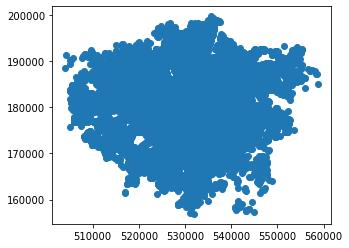

In [15]:
#check the geodataframe with a quick plot
gdf.plot()

### Quantify Airbnb listings

<font color='red'>map with price here?</font> 


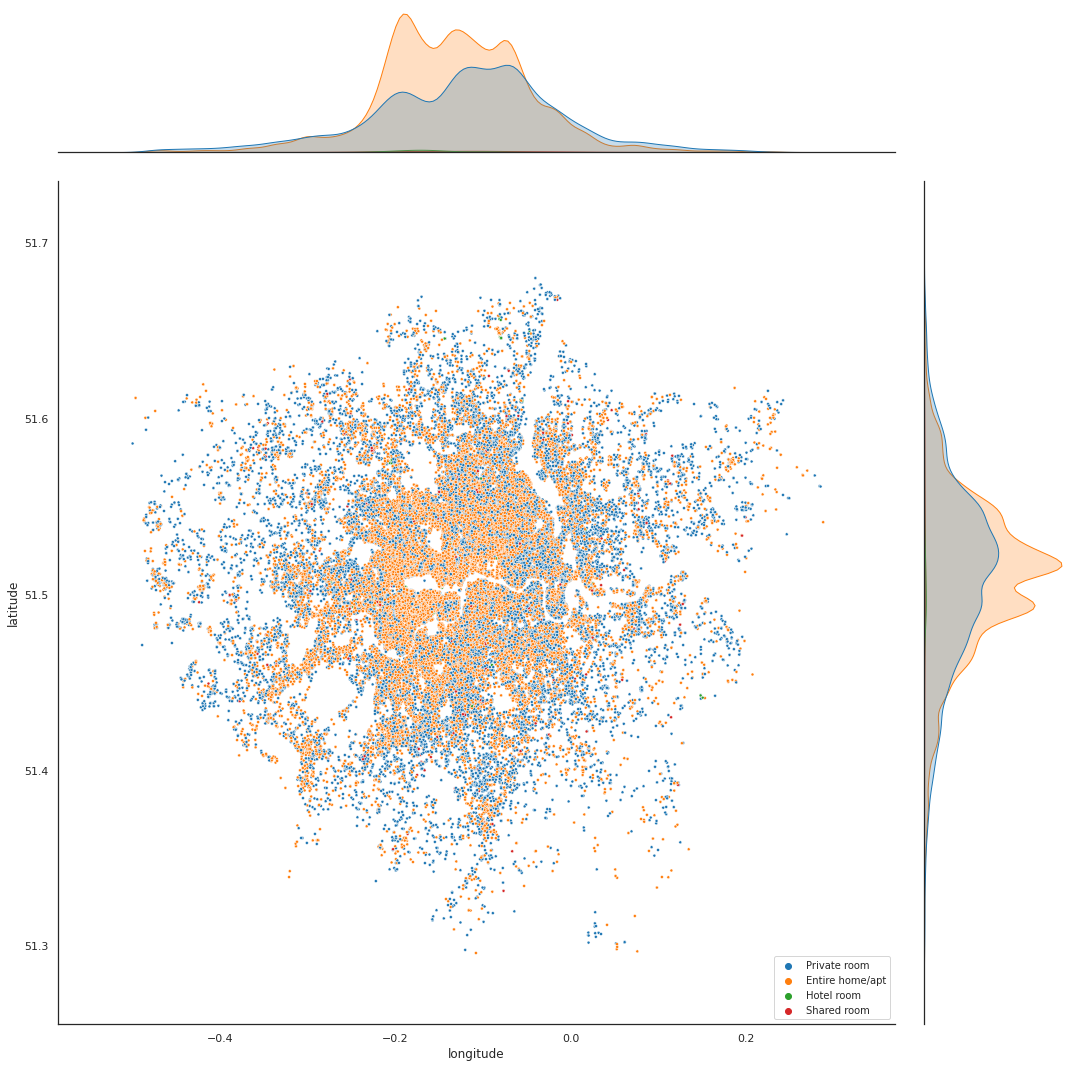

In [16]:
sns.set(style="white")
g = sns.jointplot(data=gdf, x='longitude', y='latitude', marker=".",
                  hue='room_type', height=15 ,palette="tab10" )
g.ax_joint.legend(loc='lower right', prop={'size': 10});


Visualise the Airbnb listings across London to get a first impression of the amount of listings in the city.
It would also be interesting to separate and plot a comparison between active and inactive Listings across London 

In order to filter out the active listings , this analysis will consider the last review date as indicator. 
Any review in the past year from the date the data was compiled (2021-10-10) will deem the listing active

In [17]:
gdf.sample(4, random_state=42)

,name,latitude,longitude,property_type,room_type,price,availability_365,number_of_reviews_l30d,first_review,last_review,geometry
id,,,,,,,,,,,
42409608,Cosy two bedroom home full of character,51.43951,-0.19965,Entire rental unit,Entire home/apt,$100.00,0,0,NaN,NaN,POINT (525228.295 172705.369)
39318693,Frills-free yet Clean and Comfortable Bedroom,51.51699,-0.06882,Private room in condominium (condo),Private room,$17.00,0,0,2019-10-25,2019-10-27,POINT (534093.520 181552.877)
29555250,Unmissable Luxurious Mews House in Central London,51.49980,-0.14976,Entire residential home,Entire home/apt,$625.00,200,0,2019-01-11,2018-12-19,POINT (528526.190 179496.193)
19248360,Wonderful Private room+tea/coffee&sweets,51.53640,0.01036,Private room in rental unit,Private room,$25.00,0,0,2017-06-25,2018-10-11,POINT (539527.700 183859.253)


In [18]:
# convert the values in the last review column to datetime type
gdf["last_review "]= pd.to_datetime(gdf["last_review"], format='%Y-%m-%d')
#check
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 67903 entries, 13913 to 52717191
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   name                    67879 non-null  object        
 1   latitude                67903 non-null  float64       
 2   longitude               67903 non-null  float64       
 3   property_type           67903 non-null  object        
 4   room_type               67903 non-null  object        
 5   price                   67903 non-null  object        
 6   availability_365        67903 non-null  int64         
 7   number_of_reviews_l30d  67903 non-null  int64         
 8   first_review            48875 non-null  object        
 9   last_review             48875 non-null  object        
 10  geometry                67903 non-null  geometry      
 11  last_review             48875 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2

In [19]:
# first remove the columns with no info for "last review" 
active_gdf = gdf.drop(gdf[gdf.last_review.isna()].index.values, axis=0)
# Filter for active listings
active_gdf = gdf.loc[gdf["last_review"] >= '2020-10-10']

# Display
active_gdf.sample(4, random_state=42)

,name,latitude,longitude,property_type,room_type,price,availability_365,number_of_reviews_l30d,first_review,last_review,geometry,last_review
id,,,,,,,,,,,,
7019406,Spacious Classy Portobello Apartment,51.52359,-0.20824,Entire rental unit,Entire home/apt,$170.00,365,0,2018-08-06,2021-06-29,POINT (524402.487 182040.773),2021-06-29
51033334,Superb 1 Bed Flat - Brick Lane (Free Parking),51.52397,-0.06481,Entire condominium (condo),Entire home/apt,$110.00,0,1,2021-07-26,2021-10-04,POINT (534351.206 182336.422),2021-10-04
47173303,Beautiful room in Little Venice,51.52274,-0.19467,Private room in condominium (condo),Private room,$40.00,11,0,2020-12-27,2021-05-25,POINT (525346.187 181969.387),2021-05-25
26120791,Clean and Spacious Balcony Room - 15m to Hyde ...,51.53076,-0.18641,Private room in rental unit,Private room,$50.00,115,0,2018-07-16,2021-07-24,POINT (525897.098 182875.417),2021-07-24


In [20]:
print(f"active_gdf contains {active_gdf.shape[0]} rows.")
#print(f" The active listings are  {active_gdf.shape[0]} *100 / {gdf.shape[0]}")

active_gdf.shape[0]*100/gdf.shape[0]

active_gdf contains 13577 rows.


19.99469831966187

### Comparison map 


<font color='red'>NOTE: change colours, source?</font> 

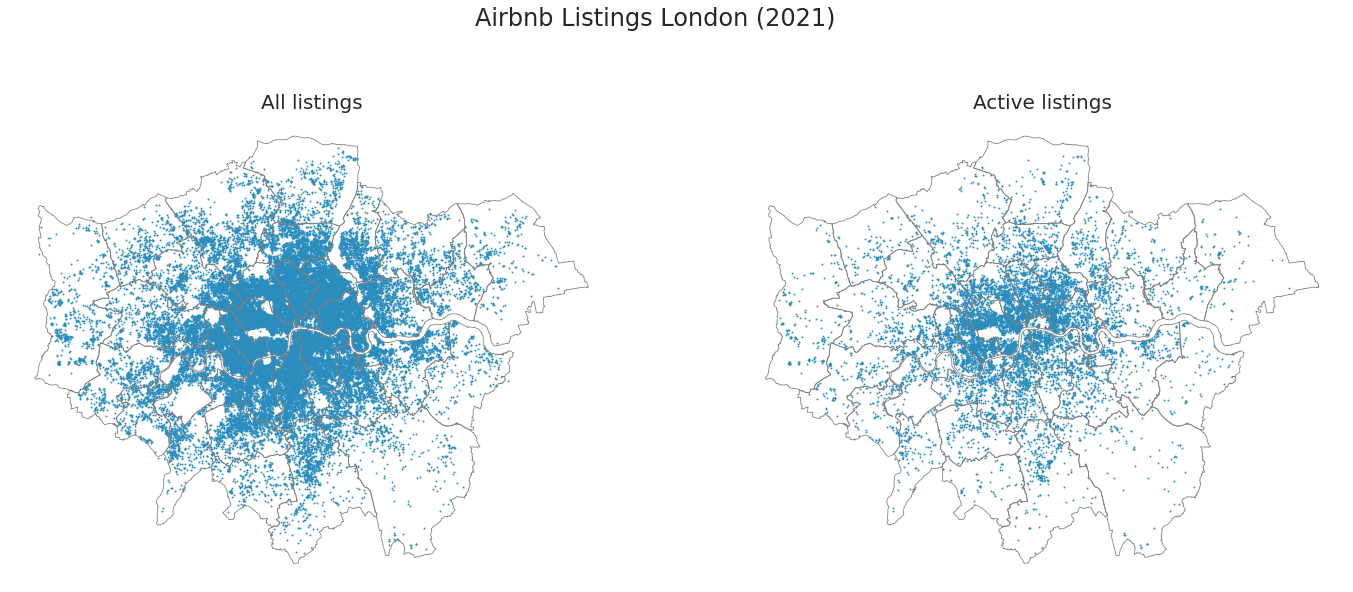

In [21]:
#create a base axis for the plot
fig, axes = plt.subplots(1,2, figsize = (24,16))


#CB = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']


plt1 = 'All listings'
plt2 = 'Active listings'

#plot the London outline 
boros.boundary.plot(ax=axes[0], edgecolor = "grey", linewidth=0.8)

#plot the airbnb listings
gdf.plot(ax = axes[0], color= "#2b8cbe" , markersize = 0.8, legend=True)



#plot the London outline 
boros.boundary.plot(ax=axes[1], edgecolor = "grey", linewidth=0.8)

#plot the active airbnb listings
active_gdf.plot(ax = axes[1], color= "#2b8cbe", markersize = 0.8, legend=True)


#set the axis off
for ax in axes:
    ax.axis('off')

#add title

fig.suptitle('Airbnb Listings London (2021)', y=0.8,ha='center', size=24)
axes[0].set_title(plt1.capitalize(), size=20)
axes[1].set_title(plt2.capitalize(), size=20)

#plt.show()

plt.savefig("Active_Airbnb_map_comparison_dots.png", bbox_inches = 'tight')

The maps above show the magnitute of the Airbnb listings count across the area of London. Even the outer Boroughs seem to a substantial amount of listings. While the active listings are significantly less, the emerging pattern remains the same: high concentration of listing in the centre that spread outwards in smaller intensity. 

# Bar chart comparing Airbnb listings density across London Borougs

In [22]:
# Join the Airbnb listings 
joined_boroughs = gpd.sjoin(gdf, boros, how='right', op='within').drop(columns=['latitude','longitude','index_left'])
joined_boroughs.head()

,name,property_type,room_type,price,availability_365,number_of_reviews_l30d,first_review,last_review,last_review,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry
0,"Spacious garden cabin, peaceful setting & homely",Private room in cabin,Private room,$55.00,25,2,2019-10-05,2021-10-04,2021-10-04,Kingston upon Thames,E09000021,3726.117,0.0,F,"MULTIPOLYGON (((516401.600 160201.800, 516407...."
0,Greater London Flat,Private room in rental unit,Private room,$80.00,173,0,NaN,NaN,NaT,Kingston upon Thames,E09000021,3726.117,0.0,F,"MULTIPOLYGON (((516401.600 160201.800, 516407...."
0,"3 bedroom flat with 4k TVs, Sky/Netflix & Parking",Entire condominium (condo),Entire home/apt,$131.00,75,2,2021-09-17,2021-09-27,2021-09-27,Kingston upon Thames,E09000021,3726.117,0.0,F,"MULTIPOLYGON (((516401.600 160201.800, 516407...."
0,Quite & Peaceful House in Chessington,Entire residential home,Entire home/apt,$130.00,226,0,NaN,NaN,NaT,Kingston upon Thames,E09000021,3726.117,0.0,F,"MULTIPOLYGON (((516401.600 160201.800, 516407...."
0,Beautiful 3 Bedroom House in Chessington Surrey,Entire residential home,Entire home/apt,$149.00,353,1,2020-05-31,2021-09-18,2021-09-18,Kingston upon Thames,E09000021,3726.117,0.0,F,"MULTIPOLYGON (((516401.600 160201.800, 516407...."


In [23]:
#insert new columns

# count of listings per ward
joined_boroughs["listings_count"]=joined_boroughs.groupby(["GSS_CODE"])["price"].transform("count")

#calculate density of listings per Borough

joined_boroughs["listings_density"]=joined_boroughs["listings_count"]/joined_boroughs["HECTARES"]
joined_boroughs.head(2)


,name,property_type,room_type,price,availability_365,number_of_reviews_l30d,first_review,last_review,last_review,NAME,GSS_CODE,HECTARES,NONLD_AREA,ONS_INNER,geometry,listings_count,listings_density
0,"Spacious garden cabin, peaceful setting & homely",Private room in cabin,Private room,$55.00,25,2,2019-10-05,2021-10-04,2021-10-04,Kingston upon Thames,E09000021,3726.117,0.0,F,"MULTIPOLYGON (((516401.600 160201.800, 516407....",489,0.131236
0,Greater London Flat,Private room in rental unit,Private room,$80.00,173,0,NaN,NaN,NaT,Kingston upon Thames,E09000021,3726.117,0.0,F,"MULTIPOLYGON (((516401.600 160201.800, 516407....",489,0.131236


In [24]:
list_boros = joined_boroughs.groupby(["GSS_CODE","NAME"]).sum().drop(columns=["availability_365","number_of_reviews_l30d","NONLD_AREA"]).reset_index().sort_values("listings_density", ascending=False)
list_boros

,GSS_CODE,NAME,HECTARES,listings_count,listings_density
32,E09000033,Westminster,1.592552e+07,52258441,23721.435494
19,E09000020,Kensington and Chelsea,5.929359e+06,22924944,18512.058102
29,E09000030,Tower Hamlets,1.225245e+07,32251041,14948.331890
11,E09000012,Hackney,9.863583e+06,26811684,14075.098876
18,E09000019,Islington,5.835688e+06,15429184,10385.379197
6,E09000007,Camden,1.006449e+07,21335161,9791.568071
27,E09000028,Southwark,1.198929e+07,16064064,5370.189948
12,E09000013,Hammersmith and Fulham,5.206266e+06,9211225,5369.696090
21,E09000022,Lambeth,1.034932e+07,14424804,5293.622612
31,E09000032,Wandsworth,1.243626e+07,12467961,3540.000886


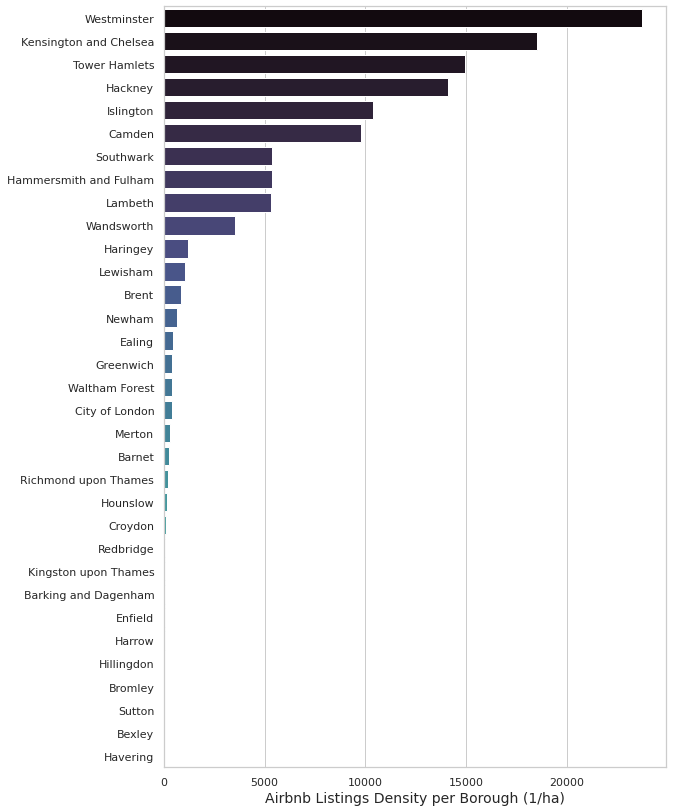

In [25]:
# create bar chart
sns.set(style="whitegrid")
#sns.set_theme(style='darkgrid')
plt.figure(figsize=(9, 14))

ax = sns.barplot( x="listings_density",
                  y="NAME", 
                 #hue="room_type",
                  data=list_boros,
                  order = list_boros["NAME"],
                  palette="mako")

plt.xlabel("Airbnb Listings Density per Borough (1/ha)", size=14)
plt.ylabel(None, size=14)


plt.savefig("Barplot_Listings_Density_per_Borough.png", bbox_inches = 'tight')

# Spacial unit

The London Boroughs are relatively large spacial units that will not capture more fine grained variation across the city's urban fabric. Therefore the subsequent analysis will be based on smaller spacial unit the Greater London Wards. These are chosen above MSOAs or LSOAs, in order to make use of the London Wards Profiles from the London Datastore that provides key summary measures that will be used in this analysis. (+see literature and explain better)

"The ward profiles and ward atlas provide a range of demographic and related data for each ward in Greater London. They are designed to provide an overview of the population in these small areas by presenting a range of data on the population, diversity, households, life expectancy, housing, crime, benefits, land use, deprivation, and employment" (source:https://data.london.gov.uk/dataset/ward-profiles-and-atlas)

Following data sets will be used:
* London Wards geopackage
* London Wards csv file

## London Wards (geometry)

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


<AxesSubplot:>

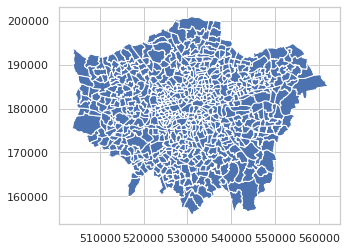

In [26]:
# load the wards geopackage
wards_geo = gpd.read_file('https://github.com/DaphneBdn/fsds_assessment3/blob/main/Data/geo/london_wards.gpkg?raw=true')
wards_geo.plot()

In [27]:
#make sure the crs in BNG
wards_geo = wards_geo.to_crs('epsg:27700')

In [28]:
#check there are no NA values
wards_geo[wards_geo.isna().any(axis=1)]

,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry


## London Ward Profiles (data)

In [29]:
# Load in the Ward profiles
ward_profiles = pd.read_csv('https://github.com/DaphneBdn/fsds_assessment3/blob/main/Data/raw/ward-profiles-excel-version.csv?raw=true',encoding= 'latin-1')
ward_profiles.tail(3)

,Ward name,Old code,New code,Population - 2015,Children aged 0-15 - 2015,Working-age (16-64) - 2015,Older people aged 65+ - 2015,% All Children aged 0-15 - 2015,% All Working-age (16-64) - 2015,% All Older people aged 65+ - 2015,...,A-Level Average Point Score Per Student - 2013/14,A-Level Average Point Score Per Entry; 2013/14,Crime rate - 2014/15,Violence against the person rate - 2014/15,"Deliberate Fires per 1,000 population - 2014",% area that is open space - 2014,Cars per household - 2011,Average Public Transport Accessibility score - 2014,% travel by bicycle to work - 2011,Turnout at Mayoral election - 2012
657,Westminster,00BK,E09000033,230550.0,33900.0,170350.0,26300.0,14.7,73.9,11.4,...,680.5,210.2,238.3,39.5,0.2,28.6,0.5,6.5,4.8,37.7
658,London,H,E12000007,8632850.0,1726900.0,5923600.0,982400.0,20.0,68.6,11.4,...,689.9,211.4,83.3,23.4,0.5,39.1,0.8,3.8,4.0,34.2
659,England,921,E92000001,54613400.0,10335450.0,34540350.0,9737650.0,18.9,63.2,17.8,...,696.3,211.5,66.9,13.4,NaN,NaN,1.1,NaN,2.9,NaN


For the purposes of this analysis, just a small subset of variables will be used for the classification of the London wards. 

Using the already standardised measures available following variables are selected:
* Median Age
* Population Density
* Percentage of BAME
* Median Household income (estimate)
* Percentage of Flats,maisonettes or apartments
* Percentage of population with higher education 
* Average public Transport Accessiblity score

The selection, whilst not exhaustive , aims to capture geodeographic, social and economic characteristics of the subregions.

In [30]:
# store variables of interest in a list
keep_ward=["Ward name",
          "New code",
           "Median Age - 2013", 
           "Population density (persons per sq km) - 2013",
           "% BAME - 2011",
           "Median Household income estimate (2012/13)",
           "% Flat, maisonette or apartment - 2011",
           "% with Level 4 qualifications and above - 2011",
           "Average Public Transport Accessibility score - 2014" ]
# subset the dataframe
wards=ward_profiles[keep_ward]
# tidy up the column names
wards = wards.rename(columns={'Area_name':'Borough',
                          "New code":'Ward code',
                          "Median Age - 2013": "Median Age",
                          "Population density (persons per sq km) - 2013":"Pop density",
                          "% BAME - 2011":"BAME perc",
                          "Median Household income estimate (2012/13)":"Median income",
                          "% Flat, maisonette or apartment - 2011": "Flat perc",
                          "% with Level 4 qualifications and above - 2011": "High educ perc",
                          "Average Public Transport Accessibility score - 2014": "Transport"})
wards.tail()

,Ward name,Ward code,Median Age,Pop density,BAME perc,Median income,Flat perc,High educ perc,Transport
655,Waltham Forest,E09000031,33.0,6897.0,47.8,39460.0,41.2,30.0,3.6
656,Wandsworth,E09000032,32.0,8853.9,28.6,66220.0,65.9,53.6,4.3
657,Westminster,E09000033,34.0,10285.8,38.3,80760.0,89.2,50.3,6.5
658,London,E12000007,33.0,5292.6,40.2,51770.0,52.2,37.7,3.8
659,England,E92000001,39.0,413.5,14.6,30763.3,21.6,27.2,NaN


The last two etries are not wards but seem to be a London and England wide summary. These rows will be removed

In [32]:
wards.drop(index=[658,659], inplace=True)
wards.tail()

,Ward name,Ward code,Median Age,Pop density,BAME perc,Median income,Flat perc,High educ perc,Transport
653,Sutton,E09000029,38.0,4480.3,21.4,49170.0,35.4,30.1,2.9
654,Tower Hamlets,E09000030,29.0,12564.7,54.8,45720.0,85.9,41.0,5.0
655,Waltham Forest,E09000031,33.0,6897.0,47.8,39460.0,41.2,30.0,3.6
656,Wandsworth,E09000032,32.0,8853.9,28.6,66220.0,65.9,53.6,4.3
657,Westminster,E09000033,34.0,10285.8,38.3,80760.0,89.2,50.3,6.5


In [33]:
# check for other NA values
wards[wards.isna().any(axis=1)]

,Ward name,Ward code,Median Age,Pop density,BAME perc,Median income,Flat perc,High educ perc,Transport


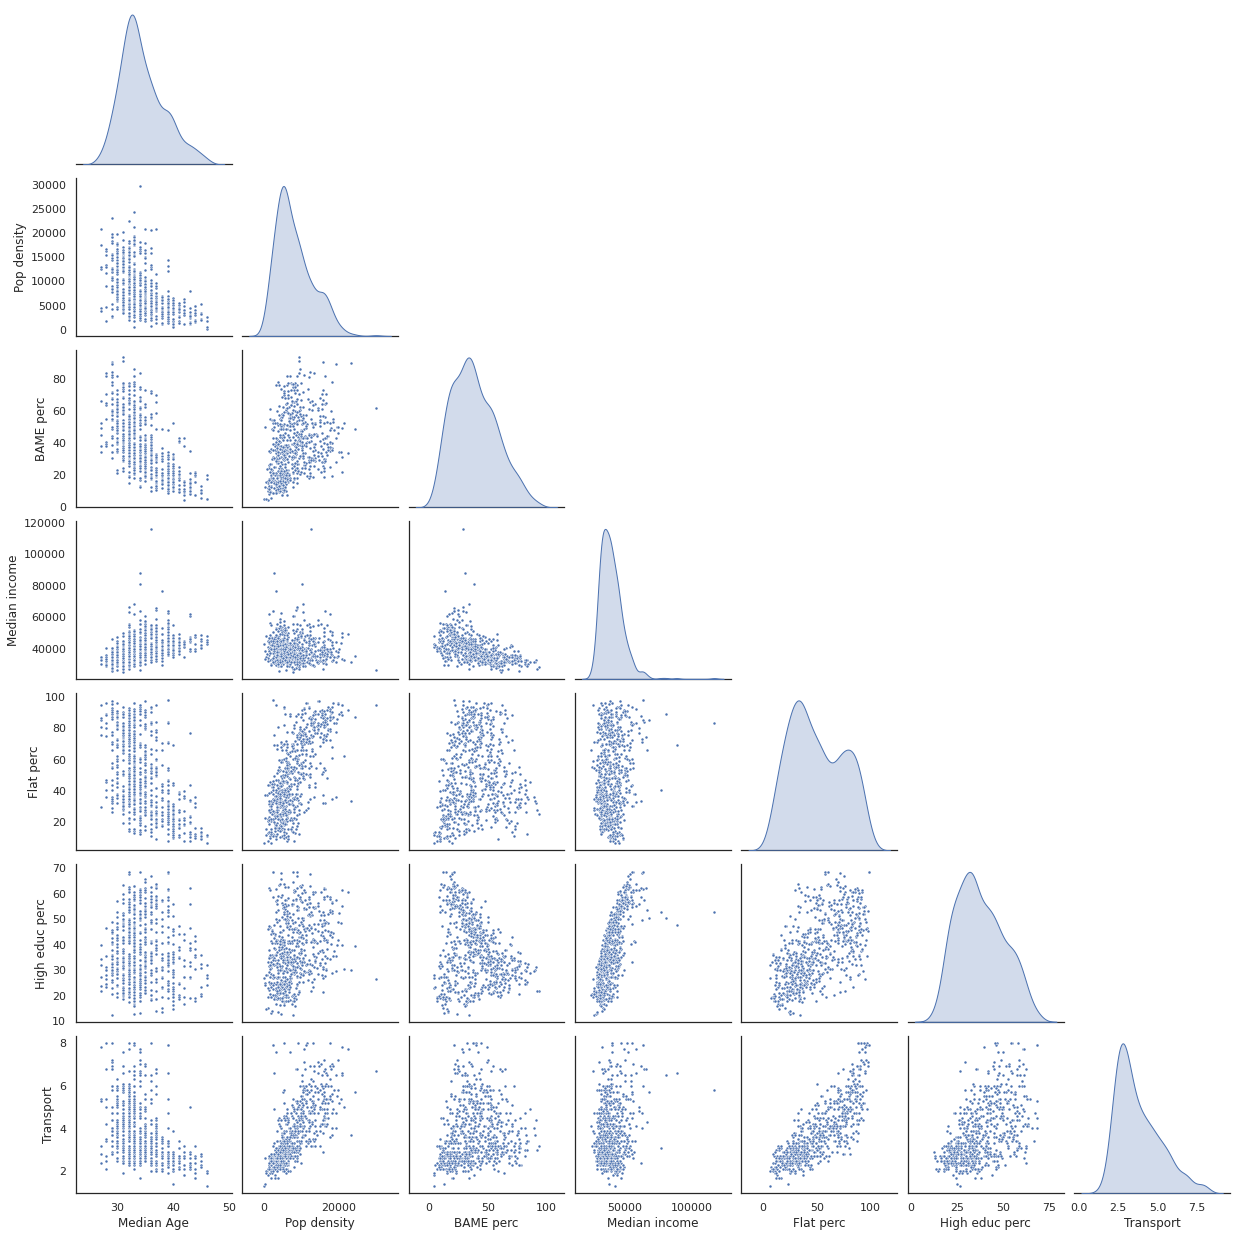

In [34]:
# using a quick plot to visualise the distribution of the variables
sns.set(style="white")
sns.pairplot(data=wards, markers=".", diag_kind='kde', corner=True)

### JOIN THE DATA

After joining the airbnb listings to the wards geometry, the count and density of listings per Ward is calculeted. This is then plotten on a map

NOTE: USING ACTIVE LISTINGS ONLY

In [37]:
joined_wards = gpd.sjoin(active_gdf, wards_geo, how='right', op='within').drop(columns=['latitude','longitude','index_left'])
joined_wards.head()


,name,property_type,room_type,price,availability_365,number_of_reviews_l30d,first_review,last_review,last_review,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry
0,Cosy detached studio- walking distance to CWOA!,Entire guesthouse,Entire home/apt,$86.00,316.0,7.0,2021-05-01,2021-10-09,2021-10-09,Chessington South,E05000405,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((516401.600 160201.800, 516407.300 16..."
0,Chessington Retreat Near World of Adventures,Entire residential home,Entire home/apt,$86.00,18.0,1.0,2019-08-02,2021-10-10,2021-10-10,Chessington South,E05000405,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((516401.600 160201.800, 516407.300 16..."
0,Chessington Staycation : Close to CWOAResort...,Entire residential home,Entire home/apt,$154.00,259.0,2.0,2021-08-28,2021-09-27,2021-09-27,Chessington South,E05000405,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((516401.600 160201.800, 516407.300 16..."
0,"Spacious garden cabin, peaceful setting & homely",Private room in cabin,Private room,$55.00,25.0,2.0,2019-10-05,2021-10-04,2021-10-04,Chessington South,E05000405,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((516401.600 160201.800, 516407.300 16..."
0,"3 bedroom flat with 4k TVs, Sky/Netflix & Parking",Entire condominium (condo),Entire home/apt,$131.00,75.0,2.0,2021-09-17,2021-09-27,2021-09-27,Chessington South,E05000405,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((516401.600 160201.800, 516407.300 16..."


In [38]:
#insert new columns

# count of listings per ward
joined_wards["listings_count"]=joined_wards.groupby(["GSS_CODE"])["price"].transform("count")

In [39]:
#calculate density of listings per ward

joined_wards["listings_density"]=joined_wards["listings_count"]/joined_wards["HECTARES"]
joined_wards.head(2)


,name,property_type,room_type,price,availability_365,number_of_reviews_l30d,first_review,last_review,last_review,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry,listings_count,listings_density
0,Cosy detached studio- walking distance to CWOA!,Entire guesthouse,Entire home/apt,$86.00,316.0,7.0,2021-05-01,2021-10-09,2021-10-09,Chessington South,E05000405,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((516401.600 160201.800, 516407.300 16...",8,0.010594
0,Chessington Retreat Near World of Adventures,Entire residential home,Entire home/apt,$86.00,18.0,1.0,2019-08-02,2021-10-10,2021-10-10,Chessington South,E05000405,755.173,0.0,E09000021,Kingston upon Thames,50840,"POLYGON ((516401.600 160201.800, 516407.300 16...",8,0.010594


In [40]:
# change the 0 values to 0.0001 in the listings_density columns so that log transformation will work
# no_listings = joined_wards.index[joined_wards['listings_count']==0].tolist()

for x in joined_wards.loc[joined_wards['listings_count']==0].index:
    joined_wards.at[x,"listings_density"]=0.0001

# check it worked
joined_wards.loc[joined_wards["listings_density"]==0]

,name,property_type,room_type,price,availability_365,number_of_reviews_l30d,first_review,last_review,last_review,NAME,GSS_CODE,HECTARES,NONLD_AREA,LB_GSS_CD,BOROUGH,POLY_ID,geometry,listings_count,listings_density


<AxesSubplot:ylabel='Frequency'>

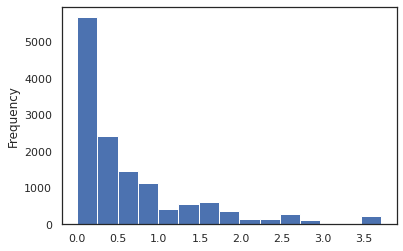

In [41]:
# plot histogram of the listings distribution 
joined_wards['listings_density'].plot.hist(bins=15) 

In [42]:
# add a column taking the log 
joined_wards["ln_listings_density"]= np.log(joined_wards["listings_density"])

<AxesSubplot:ylabel='Frequency'>

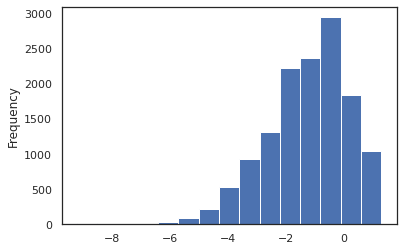

In [43]:
joined_wards['ln_listings_density'].plot.hist(bins=15) # histogram

The ditribution of listings is heavily positively skewed. 
After log transforming the data the distribution seems slightly more normal

<Axes:>

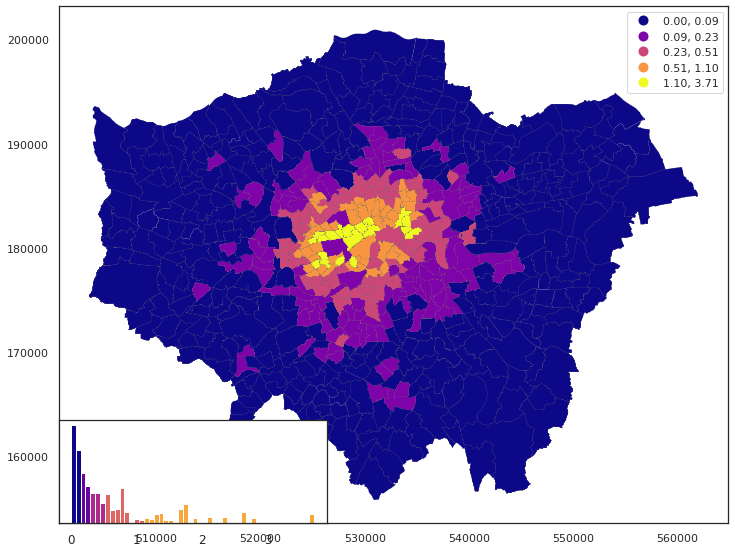

In [44]:
import pysal as ps
# https://github.com/pysal/mapclassify
import mapclassify as mc
# https://jiffyclub.github.io/palettable/
import palettable.matplotlib as palmpl
from legendgram import legendgram

f,ax = plt.subplots(figsize=(12,10))
joined_wards.plot(column='listings_density', scheme='quantiles', cmap='plasma',edgecolor='grey',linewidth=0.1, k=5, ax=ax, legend=True)
q = mc.Quantiles(joined_wards.listings_density.values, k=5)

# https://github.com/pysal/legendgram/blob/master/legendgram/legendgram.py
legendgram(f, ax, 
               joined_wards.listings_density, q.bins, pal=palmpl.Plasma_5,
               legend_size=(.4,.2), # legend size in fractions of the axis
               loc = 'lower left', # mpl-style legend loc
              # clip = (0,500), # clip range of the histogram
               frameon=True)

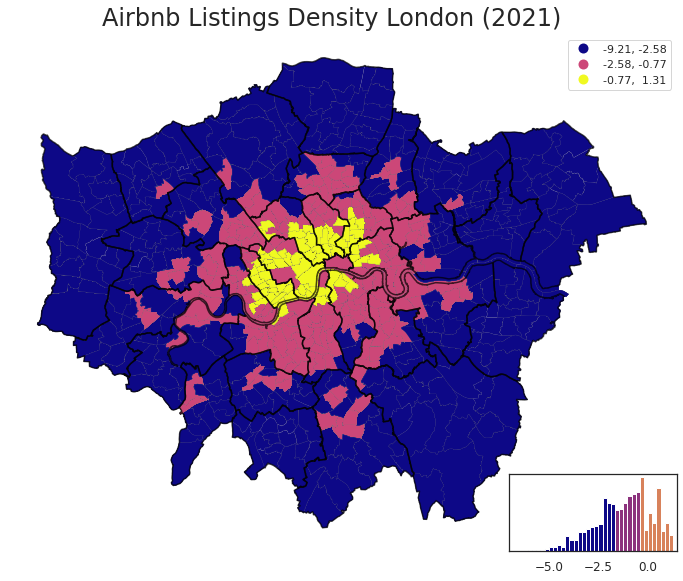

In [45]:
import pysal as ps
# https://github.com/pysal/mapclassify
import mapclassify as mc
# https://jiffyclub.github.io/palettable/
import palettable.matplotlib as palmpl
from legendgram import legendgram

f,ax = plt.subplots(figsize=(12,10))

f.suptitle('Airbnb Listings Density London (2021)', y=0.9,ha='center', size=24)

boros.boundary.plot(ax = ax, color = "black", alpha = 0.7)
joined_wards.plot(column='ln_listings_density', scheme='naturalbreaks', cmap='plasma',edgecolor='grey',linewidth=0.1, k=3, ax=ax, legend=True)
q = mc.Quantiles(joined_wards.ln_listings_density.values, k=3)
#set the axis off
ax.set_axis_off()
# https://github.com/pysal/legendgram/blob/master/legendgram/legendgram.py
legendgram(f, ax, 
               joined_wards.ln_listings_density, q.bins, pal=palmpl.Plasma_3,
               legend_size=(.25,.15), # legend size in fractions of the axis
               loc = 'lower right', # mpl-style legend loc
               clip = (-7,1.5), # clip range of the histogram
               frameon=True)
plt.savefig("Airbnb_density.png", bbox_inches = 'tight')


COLORS!!!

In [46]:
#merge the profiles data with the previously joined dataframe file 
London_profiles = pd.merge( joined_wards, wards,left_on = "GSS_CODE", right_on = "Ward code", how = "left")

In [47]:
# check it is still a geodataframe
type(London_profiles)

geopandas.geodataframe.GeoDataFrame

In [48]:
London_profiles.tail(5)

,name,property_type,room_type,price,availability_365,number_of_reviews_l30d,first_review,last_review,last_review,NAME,...,ln_listings_density,Ward name,Ward code,Median Age,Pop density,BAME perc,Median income,Flat perc,High educ perc,Transport
13695,A Magnificent Studio Apartment London Tower Br...,Entire condominium (condo),Entire home/apt,$70.00,34.0,2.0,2021-09-20,2021-09-26,2021-09-26,City of London,...,-1.098431,City of London,E09000001,39.0,2538.1,21.4,63620.0,98.0,68.4,7.9
13696,Upmarket Tower of London Studio,Entire rental unit,Entire home/apt,$120.00,337.0,2.0,2016-05-17,2021-09-05,2021-09-05,City of London,...,-1.098431,City of London,E09000001,39.0,2538.1,21.4,63620.0,98.0,68.4,7.9
13697,Upmarket Tower of London Studio,Entire rental unit,Entire home/apt,$120.00,337.0,2.0,2016-05-17,2021-09-05,2021-09-05,City of London,...,-1.098431,City of London,E09000001,39.0,2538.1,21.4,63620.0,98.0,68.4,7.9
13698,Superior One Bedroom Apartment in City of London,Entire rental unit,Entire home/apt,$110.00,216.0,0.0,2020-09-06,2020-10-31,2020-10-31,City of London,...,-1.098431,City of London,E09000001,39.0,2538.1,21.4,63620.0,98.0,68.4,7.9
13699,Superior One Bedroom Apartment in City of London,Entire rental unit,Entire home/apt,$110.00,216.0,0.0,2020-09-06,2020-10-31,2020-10-31,City of London,...,-1.098431,City of London,E09000001,39.0,2538.1,21.4,63620.0,98.0,68.4,7.9


In [49]:
London_profiles.drop_duplicates(subset="GSS_CODE", inplace=True)


In [51]:
London_profiles.isna().sum()

name                      18
property_type             18
room_type                 18
price                     18
availability_365          18
number_of_reviews_l30d    18
first_review              18
last_review               18
last_review               18
NAME                       0
GSS_CODE                   0
HECTARES                   0
NONLD_AREA                 0
LB_GSS_CD                  0
BOROUGH                    0
POLY_ID                    0
geometry                   0
listings_count             0
listings_density           0
ln_listings_density        0
Ward name                  0
Ward code                  0
Median Age                 0
Pop density                0
BAME perc                  0
Median income              0
Flat perc                  0
High educ perc             0
Transport                  0
dtype: int64

In [62]:
London_profiles.drop(columns=["Ward name", "Ward code","NONLD_AREA","POLY_ID","name","property_type","room_type","price","availability_365","number_of_reviews_l30d","first_review","last_review"], inplace=True)

KeyError: "['Ward name' 'Ward code' 'NONLD_AREA' 'POLY_ID' 'name' 'property_type'\n 'room_type' 'price' 'availability_365' 'number_of_reviews_l30d'\n 'first_review' 'last_review' 'last_review'] not found in axis"

In [63]:
London_profiles.head(2)

,last_review,NAME,GSS_CODE,HECTARES,LB_GSS_CD,BOROUGH,geometry,listings_count,listings_density,ln_listings_density,Median Age,Pop density,BAME perc,Median income,Flat perc,High educ perc,Transport
0,2021-10-09,Chessington South,E05000405,755.173,E09000021,Kingston upon Thames,"POLYGON ((516401.600 160201.800, 516407.300 16...",8,0.010594,-4.547505,37.0,1375.0,13.0,38310.0,20.9,25.3,2.4
8,2021-03-20,Tolworth and Hook Rise,E05000414,259.464,E09000021,Kingston upon Thames,"POLYGON ((517829.600 165447.100, 517837.100 16...",5,0.019270,-3.949180,36.0,3961.5,27.2,37840.0,22.0,30.0,2.3


# CSR

TEXT here

In [70]:
London_profiles = London_profiles.reset_index(drop=True)

In [72]:
#import the necessary packages
from libpysal import weights

#calculate the weights matrix
wr = weights.contiguity.Rook.from_dataframe(London_profiles)

w_queen = weights.contiguity.Queen.from_dataframe(London_profiles)

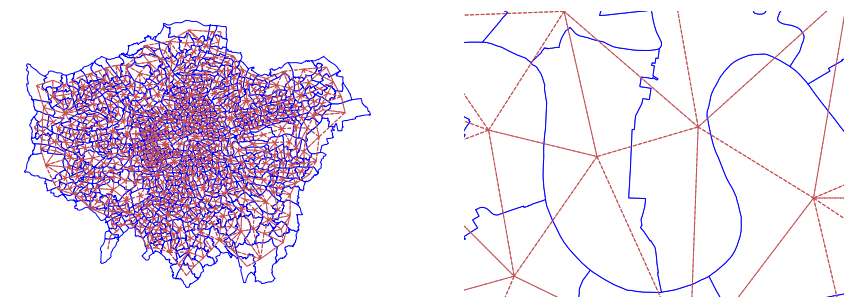

In [73]:
# code from Philip Wilkinson
#looking at London
fig, ax = plt.subplots(1,2, figsize = (15,15))

London_profiles.plot(edgecolor = "blue", facecolor = "w", ax=ax[0])

wr.plot(London_profiles, ax=ax[0],
       edge_kws=dict(color="r", linestyle = "--", linewidth =1),
       node_kws=dict(marker=''))

ax[0].set_axis_off()


#Second plot looking into deepr depth
London_profiles.plot(edgecolor = "blue", facecolor = "w", ax=ax[1])

wr.plot(London_profiles, ax=ax[1],
       edge_kws=dict(color="r", linestyle = "--", linewidth =1),
       node_kws=dict(marker=''))
#zzoming ino Canary Wharf
ax[1].axis([536_000, 540_000, 178_000, 181_000])

ax[1].set_axis_off()

RIVER IS IGNORED IN THIS SPATIAL WEIGHTS MATRIX!
a natural geographic boundary shoudnt be ingored!


# Hierarchical Clustering - listings density , checking for CSR


test hierarchical clustering on the lisitngs density column only

In [86]:
list=["GSS_CODE",
     "ln_listings_density"]

In [87]:
# subset the data
list_clust= London_profiles[list]
list_clust.set_index("GSS_CODE", inplace=True)
list_clust


,ln_listings_density
GSS_CODE,
E05000405,-4.547505
E05000414,-3.949180
E05000401,-2.899978
E05000400,-4.494261
E05000402,-3.443730
...,...
E05000042,-4.352849
E05000030,-4.745106
E05000029,-5.131146


In [88]:
#import the necessary module
from sklearn.cluster import AgglomerativeClustering

#create the model setting the number of clusters 
model = AgglomerativeClustering(linkage="ward", 
                                #define the connectivity
                                connectivity = wr.sparse,
                                distance_threshold = 4 , 
                                n_clusters=None)
#fit the model to the data
model.fit(list_clust)


AgglomerativeClustering(connectivity=<625x625 sparse matrix of type '<class 'numpy.float64'>'
	with 3540 stored elements in Compressed Sparse Row format>,
                        distance_threshold=4, n_clusters=None)

In [89]:
# add the cluster membership back to the dataframe
list_clust["Aggl_clus"] = model.labels_


/opt/conda/envs/sds2021/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [90]:
# reset the index in order to join with the shapefile on the MSOA code
list_clust.reset_index(inplace=True)
# join the dataframe to the geodataframe (Note: the geopandas dataframe needs to be the left, so that the resulting objects remains a geodataframe)
list_clust_joined= pd.merge(London_profiles, list_clust, left_on="GSS_CODE", right_on="GSS_CODE" )
#check the result
list_clust_joined.head()

,last_review,NAME,GSS_CODE,HECTARES,LB_GSS_CD,BOROUGH,geometry,listings_count,listings_density,ln_listings_density_x,Median Age,Pop density,BAME perc,Median income,Flat perc,High educ perc,Transport,ln_listings_density_y,Aggl_clus
0,2021-10-09,Chessington South,E05000405,755.173,E09000021,Kingston upon Thames,"POLYGON ((516401.600 160201.800, 516407.300 16...",8,0.010594,-4.547505,37.0,1375.0,13.0,38310.0,20.9,25.3,2.4,-4.547505,9
1,2021-03-20,Tolworth and Hook Rise,E05000414,259.464,E09000021,Kingston upon Thames,"POLYGON ((517829.600 165447.100, 517837.100 16...",5,0.019270,-3.949180,36.0,3961.5,27.2,37840.0,22.0,30.0,2.3,-3.949180,9
2,2021-09-09,Berrylands,E05000401,145.390,E09000021,Kingston upon Thames,"POLYGON ((518107.500 167303.400, 518114.300 16...",8,0.055024,-2.899978,36.0,6466.7,18.1,42330.0,54.7,48.4,2.8,-2.899978,4
3,2021-08-27,Alexandra,E05000400,268.506,E09000021,Kingston upon Thames,"POLYGON ((520480.000 166909.800, 520490.700 16...",3,0.011173,-4.494261,39.0,3537.0,29.8,41390.0,12.0,32.7,2.2,-4.494261,9
4,2021-07-06,Beverley,E05000402,187.821,E09000021,Kingston upon Thames,"POLYGON ((522071.000 168144.900, 522063.900 16...",6,0.031945,-3.443730,37.0,5447.4,32.6,40700.0,30.4,41.7,2.8,-3.443730,4


In [91]:
print(type(list_clust_joined))

<class 'geopandas.geodataframe.GeoDataFrame'>


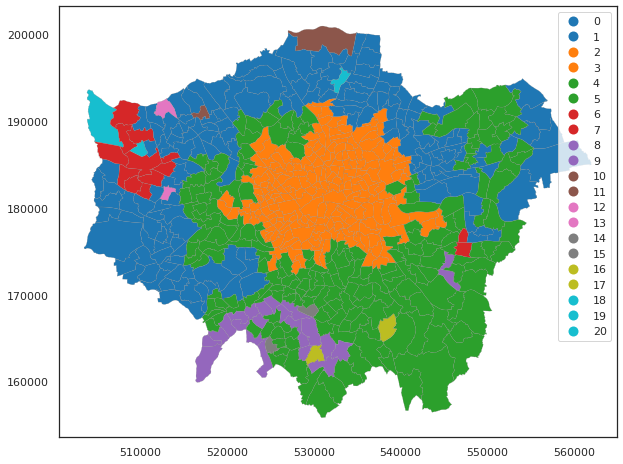

In [92]:
# map the clusters

list_clust_joined.plot(column='Aggl_clus',categorical = True, legend=True,
          edgecolor='grey',linewidth=0.2, figsize=(10,8));

ax.set_axis_off()

In [93]:
# check the size of each cluster
agglom_sizes = list_clust_joined.groupby("Aggl_clus").size()
agglom_sizes

Aggl_clus
0       7
1     157
2      98
3     114
4     127
5      75
6      11
7       2
8       2
9      21
10      1
11      1
12      1
13      1
14      1
15      1
16      1
17      1
18      1
19      1
20      1
dtype: int64

Dendogram

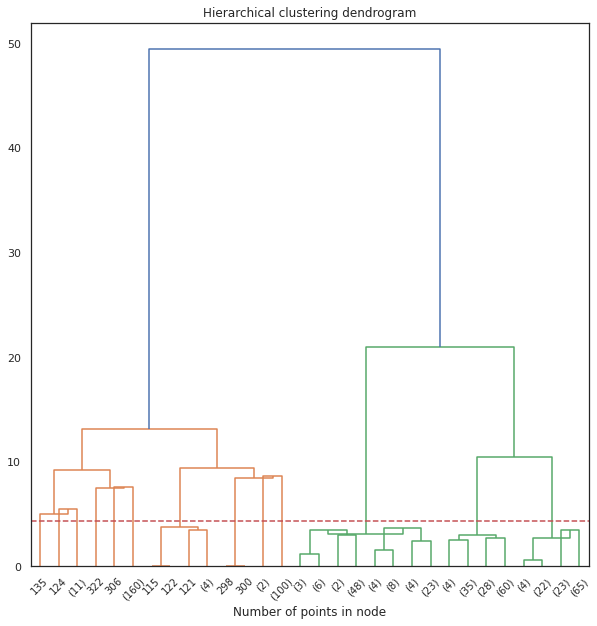

In [94]:
# the code below was copied from Philip Wilkinson: https://github.com/PhilipDW183/London_crime_clusters/blob/main/London_Crime.ipynb 

import numpy as np
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count +=1
            else:
                current_count += counts[child_idx-n_samples]
        counts[i] = current_count
        
    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                     counts]).astype(float)
    
    dendrogram(linkage_matrix, **kwargs)

fig, ax = plt.subplots(figsize = (10,10))
ax.set_title("Hierarchical clustering dendrogram")
#plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=4)
plt.axhline(y = 4.3, color = "r", linestyle = "--")
ax.set_xlabel("Number of points in node")
plt.show()

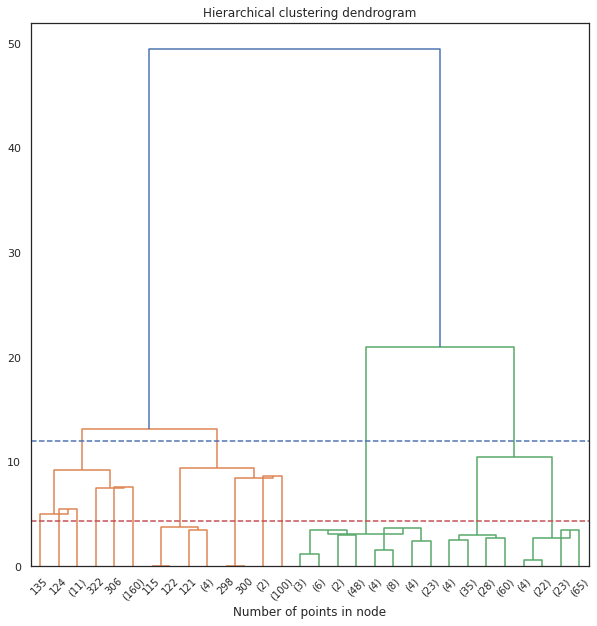

In [95]:
fig, ax = plt.subplots(figsize = (10,10))
ax.set_title("Hierarchical clustering dendrogram")
#plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=4)
plt.axhline(y = 4.3, color = "r", linestyle = "--")
plt.axhline(y = 12, color = "b", linestyle = "--")
ax.set_xlabel("Number of points in node")
plt.show()

The dendogram shows that at a slightly larger distance that the current(4), we would have one less cluster (7 and 8 should merge)
However the longest distances seem to be occur around 21, which would result into 3 clusters


In [101]:
# subset the data
list_clust= London_profiles[list]
list_clust.set_index("GSS_CODE", inplace=True)
list_clust

,ln_listings_density
GSS_CODE,
E05000405,-4.547505
E05000414,-3.949180
E05000401,-2.899978
E05000400,-4.494261
E05000402,-3.443730
...,...
E05000042,-4.352849
E05000030,-4.745106
E05000029,-5.131146


In [105]:
#Repeat the process with distance=21
model_12 = AgglomerativeClustering(linkage="ward", 
                                   #define the connectivity
                                   connectivity = wr.sparse,
                                   distance_threshold = 12 , n_clusters=None)
#fit the model to the data
model_12.fit(list_clust)

AgglomerativeClustering(connectivity=<625x625 sparse matrix of type '<class 'numpy.float64'>'
	with 3540 stored elements in Compressed Sparse Row format>,
                        distance_threshold=12, n_clusters=None)

In [106]:
# add the cluster membership back to the dataframe
list_clust_joined["Aggl_clus_12"] = model_12.labels_

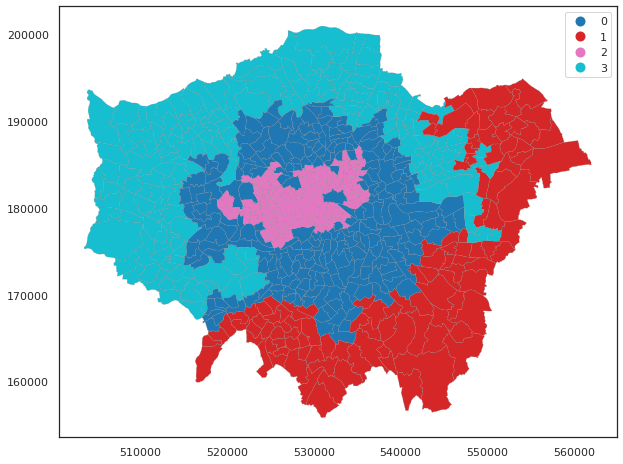

In [107]:
# map the clusters

list_clust_joined.plot(column='Aggl_clus_12',categorical = True, legend=True,
          edgecolor='grey',linewidth=0.2, figsize=(10,8));

ax.set_axis_off()

add morans I?

### title

In [108]:
# extract the column names
cols_prof=London_profiles.columns
print(cols_prof)


Index(['last_review ', 'NAME', 'GSS_CODE', 'HECTARES', 'LB_GSS_CD', 'BOROUGH',
       'geometry', 'listings_count', 'listings_density', 'ln_listings_density',
       'Median Age', 'Pop density', 'BAME perc', 'Median income', 'Flat perc',
       'High educ perc', 'Transport'],
      dtype='object')


In [109]:
colsA=['Median Age', 
       'Pop density', 
       'BAME perc',
       'Median income',
       'Flat perc', 
       'High educ perc', 
       'Transport',
       'listings_density']

clustA=London_profiles[colsA]
clustA

,Median Age,Pop density,BAME perc,Median income,Flat perc,High educ perc,Transport,listings_density
0,37.0,1375.0,13.0,38310.0,20.9,25.3,2.4,0.010594
1,36.0,3961.5,27.2,37840.0,22.0,30.0,2.3,0.019270
2,36.0,6466.7,18.1,42330.0,54.7,48.4,2.8,0.055024
3,39.0,3537.0,29.8,41390.0,12.0,32.7,2.2,0.011173
4,37.0,5447.4,32.6,40700.0,30.4,41.7,2.8,0.031945
...,...,...,...,...,...,...,...,...
620,34.0,6781.3,44.0,37180.0,27.8,22.4,2.9,0.012870
621,36.0,3028.6,24.8,37400.0,18.4,18.5,2.3,0.008694
622,34.0,2985.3,37.9,33920.0,34.5,19.5,2.3,0.005910
623,33.0,8250.0,30.9,31860.0,12.6,16.0,2.7,0.016079


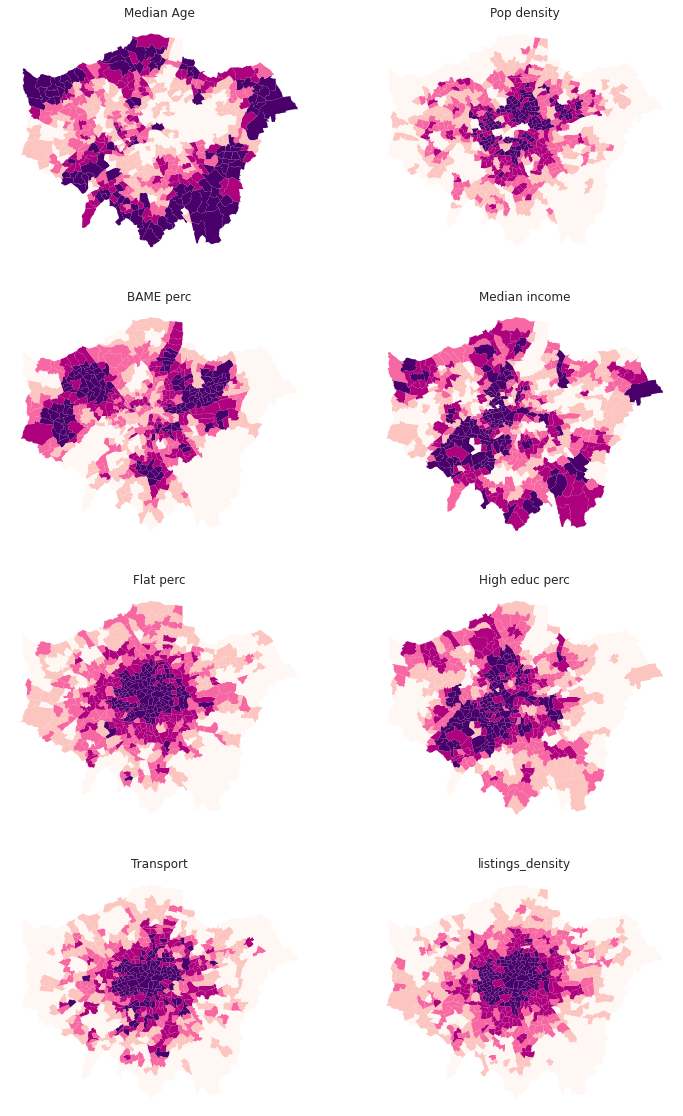

In [110]:
f, axs = plt.subplots(nrows=4, ncols=2, figsize=(12, 20))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(colsA):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    London_profiles.plot(
        column=col, 
        ax=ax,
        scheme='Quantiles', 
        linewidth=0,
        cmap='RdPu'
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()

In [111]:
clustA.tail(5)

,Median Age,Pop density,BAME perc,Median income,Flat perc,High educ perc,Transport,listings_density
620,34.0,6781.3,44.0,37180.0,27.8,22.4,2.9,0.012870
621,36.0,3028.6,24.8,37400.0,18.4,18.5,2.3,0.008694
622,34.0,2985.3,37.9,33920.0,34.5,19.5,2.3,0.005910
623,33.0,8250.0,30.9,31860.0,12.6,16.0,2.7,0.016079
624,39.0,2538.1,21.4,63620.0,98.0,68.4,7.9,0.333394


In [112]:
clustA.describe()

,Median Age,Pop density,BAME perc,Median income,Flat perc,High educ perc,Transport,listings_density
count,625.000000,625.00000,625.00000,625.000000,625.000000,625.000000,625.000000,625.000000
mean,34.475200,8243.20928,38.74112,39263.696000,49.715360,37.657760,3.769440,0.189171
std,3.947952,4865.82939,18.92150,7454.236401,24.608203,12.859171,1.399912,0.373462
min,27.000000,181.00000,4.10000,25090.000000,6.300000,12.500000,1.300000,0.000100
25%,32.000000,4710.50000,23.50000,33600.000000,29.400000,27.300000,2.700000,0.017337
50%,34.000000,7050.00000,36.10000,38200.000000,46.100000,35.500000,3.400000,0.054867
75%,37.000000,10961.50000,52.30000,43470.000000,71.400000,47.000000,4.600000,0.184323
max,46.000000,29750.00000,93.70000,88330.000000,98.000000,68.700000,8.000000,3.709458
